In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:



# -------------------------------
# Funciones auxiliares
# -------------------------------

def generate_patterns(N, p):
    """Genera p patrones binarios ±1 de longitud N"""
    return np.where(np.random.rand(p, N) < 0.5, -1, 1)

def hebbian_weights(patterns):
    """Calcula matriz de pesos Hebbianos"""
    p, N = patterns.shape
    W = (patterns.T @ patterns) / N
    np.fill_diagonal(W, 0.0)
    return W

def sign_vec(x):
    """Signo con sign(0)=+1"""
    s = np.sign(x)
    s[s == 0] = 1
    return s.astype(int)

def parallel_dynamics(W, s0, var =0, max_iters=100):
    """Dinámica paralela"""
    s = s0.copy()
    for it in range(max_iters):
        noise = np.random.normal(0, var, size=s.shape) # ruido gaussiano
        s_new = sign_vec(W @ s + noise) # actualización paralela
        if np.array_equal(s_new, s):
            return s_new, it+1
        s = s_new
    return s, max_iters

def sequential_dynamics(W, s0, max_iters=100):
    """Dinámica secuencial"""
    s = s0.copy()
    N = len(s)
    for it in range(max_iters):
        changed = False
        for i in np.random.permutation(N):
            h = W[i,:] @ s # campo local
            new_si = 1 if h >= 0 else -1
            if new_si != s[i]: # solo actualizar si cambia
                s[i] = new_si # actualizar estado
                changed = True
        if not changed:
            return s, it+1
    return s, max_iters

def overlaps(s, patterns):
    """Calcula overlaps con todos los patrones almacenados"""
    return (patterns @ s) / s.size

def synaptic_degradation(W, gamma):
    """
    gamma ∈ [0,1]: fraction of synapses removed
    """
    N = W.shape[0]

    mask_upper = np.random.rand(N, N) > gamma
    mask = np.triu(mask_upper, 1)
    mask = mask + mask.T

    W_deg = W * mask
    np.fill_diagonal(W_deg, 0)
    return W_deg
    # mask = np.random.rand(*W.shape) > gamma
    # W_deg = W * mask
    # np.fill_diagonal(W_deg, 0)
    # return W_deg


def corrupt_pattern(pattern, corruption):
    """
    corruption ∈ [0,1]: fraction of flipped bits
    """
    s = pattern.copy()
    idx = np.random.choice(len(s), int(corruption*len(s)), replace=False)
    s[idx] *= -1
    return s


def weight_decay(W, lam, t):
    '''Models long-term forgetting'''
    return np.exp(-lam*t) * W


def erase_pattern(W, pattern, strength=1.0):
    '''Models retrograde amnesia by removing a pattern from the weight matrix'''
    N = len(pattern)
    return W - strength * np.outer(pattern, pattern) / N

def mutual_information_from_overlap(m):
    pe = (1 - m) / 2
    if pe <= 0 or pe >= 1:
        return 1.0 if pe == 0 else 0.0
    H = -pe*np.log2(pe) - (1-pe)*np.log2(1-pe)
    return 1 - H

# ----------------------------------------
# Kinouchi-style unlearning
# ----------------------------------------

def unlearning_step(W, state, eta=0.05):
    """
    Anti-Hebbian update along visited attractor
    """
    N = len(state)
    return W - eta * np.outer(state, state) / N




C:\Users\solan\AppData\Local\Temp\ipykernel_14292\141955945.py:142: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


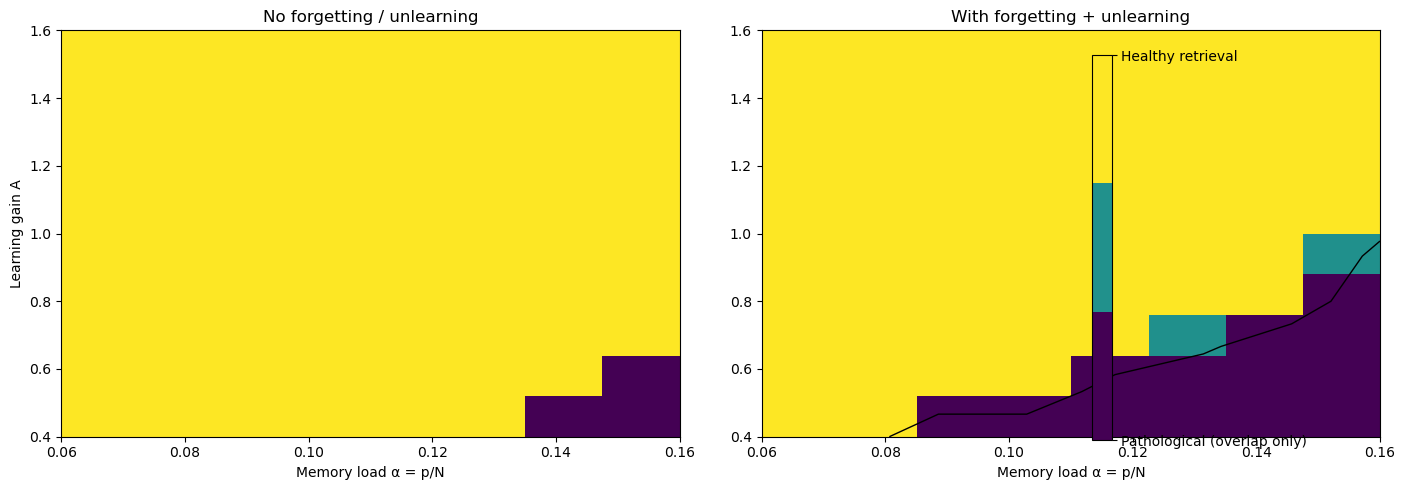

In [6]:


# =====================================================
# Parameters
# =====================================================
N = 1000
#alphas = np.linspace(0.04, 0.18, 10)
alphas = np.linspace(0.06, 0.16, 8)
A_vals = np.linspace(0.4, 1.6, 10)

noise_var = 0.1
max_tests = 30
trials = 10

# forgetting / pathology
lam = 0.01          # weight decay rate
eta = 0.02          # unlearning rate
T_forget = 10       # forgetting steps

I_c = 0.05
m_c = 0.1

# =====================================================
# Mean mutual information (YOUR definition)
# =====================================================
def mean_mutual_information(W, patterns, noise_var=0.1, max_tests=30):
    infos = []
    N = patterns.shape[1]

    for i in range(min(len(patterns), max_tests)):
        s0 = patterns[i].copy()
        sf, _ = parallel_dynamics(W, s0, var=noise_var)
        m = (patterns[i] @ sf) / N
        infos.append(mutual_information_from_overlap(m))

    return np.mean(infos)

def mean_overlap(W, patterns, noise_var=0.1, max_tests=30):
    ms = []
    N = patterns.shape[1]

    for i in range(min(len(patterns), max_tests)):
        s0 = patterns[i].copy()
        sf, _ = parallel_dynamics(W, s0, var=noise_var)
        ms.append((patterns[i] @ sf) / N)

    return np.mean(np.abs(ms))

# =====================================================
# Phase classification
# 0 = no retrieval
# 1 = pathological (overlap only)
# 2 = healthy retrieval
# =====================================================
def classify_phase(m, I):
    if m < m_c:
        return 0
    if I < I_c:
        return 1
    return 2

# =====================================================
# Phase diagrams
# =====================================================
phase_no_pathology = np.zeros((len(A_vals), len(alphas)))
phase_pathology = np.zeros_like(phase_no_pathology)

for iA, A in enumerate(A_vals):
    for ia, alpha in enumerate(alphas):

        p = int(alpha * N)
        if p < 2:
            continue

        cls_np, cls_p = [], []

        for _ in range(trials):
            patterns = generate_patterns(N, p)
            W = hebbian_weights(patterns)
            W *= A   # learning gain

            # -------- No pathology --------
            m = mean_overlap(W, patterns, noise_var, max_tests)
            I = mean_mutual_information(W, patterns, noise_var, max_tests)
            cls_np.append(classify_phase(m, I))

            # -------- With pathology --------
            Wp = W.copy()
            for t in range(T_forget):
                Wp = weight_decay(Wp, lam, t+1)

                # unlearning along retrieved state
                #s, _ = parallel_dynamics(Wp, patterns[0], var=noise_var)
                i = np.random.randint(len(patterns))
                s, _ = parallel_dynamics(Wp, patterns[i])

                Wp = unlearning_step(Wp, s, eta=eta)

            m = mean_overlap(Wp, patterns, noise_var, max_tests)
            I = mean_mutual_information(Wp, patterns, noise_var, max_tests)
            cls_p.append(classify_phase(m, I))

        phase_no_pathology[iA, ia] = np.mean(cls_np)
        phase_pathology[iA, ia] = np.mean(cls_p)

# =====================================================
# Plot
# =====================================================
labels = [
    "No retrieval",
    "Pathological (overlap only)",
    "Healthy retrieval"
]

cmap = plt.get_cmap("viridis", 3)

fig, axs = plt.subplots(1, 2, figsize=(14,5))

im = axs[0].imshow(
    phase_no_pathology, origin="lower", aspect="auto",
    extent=[alphas[0], alphas[-1], A_vals[0], A_vals[-1]],
    cmap=cmap
)
axs[0].set_title("No forgetting / unlearning")
axs[0].set_xlabel("Memory load α = p/N")
axs[0].set_ylabel("Learning gain A")

im = axs[1].imshow(
    phase_pathology, origin="lower", aspect="auto",
    extent=[alphas[0], alphas[-1], A_vals[0], A_vals[-1]],
    cmap=cmap
)
axs[1].set_title("With forgetting + unlearning")
axs[1].set_xlabel("Memory load α = p/N")
axs[1].contour(
    alphas, A_vals, phase_pathology,
    levels=[0.5, 1.5], colors='k', linewidths=1
)


cbar = fig.colorbar(im, ax=axs, ticks=[0,1,2])
cbar.ax.set_yticklabels(labels)

plt.tight_layout()
plt.show()


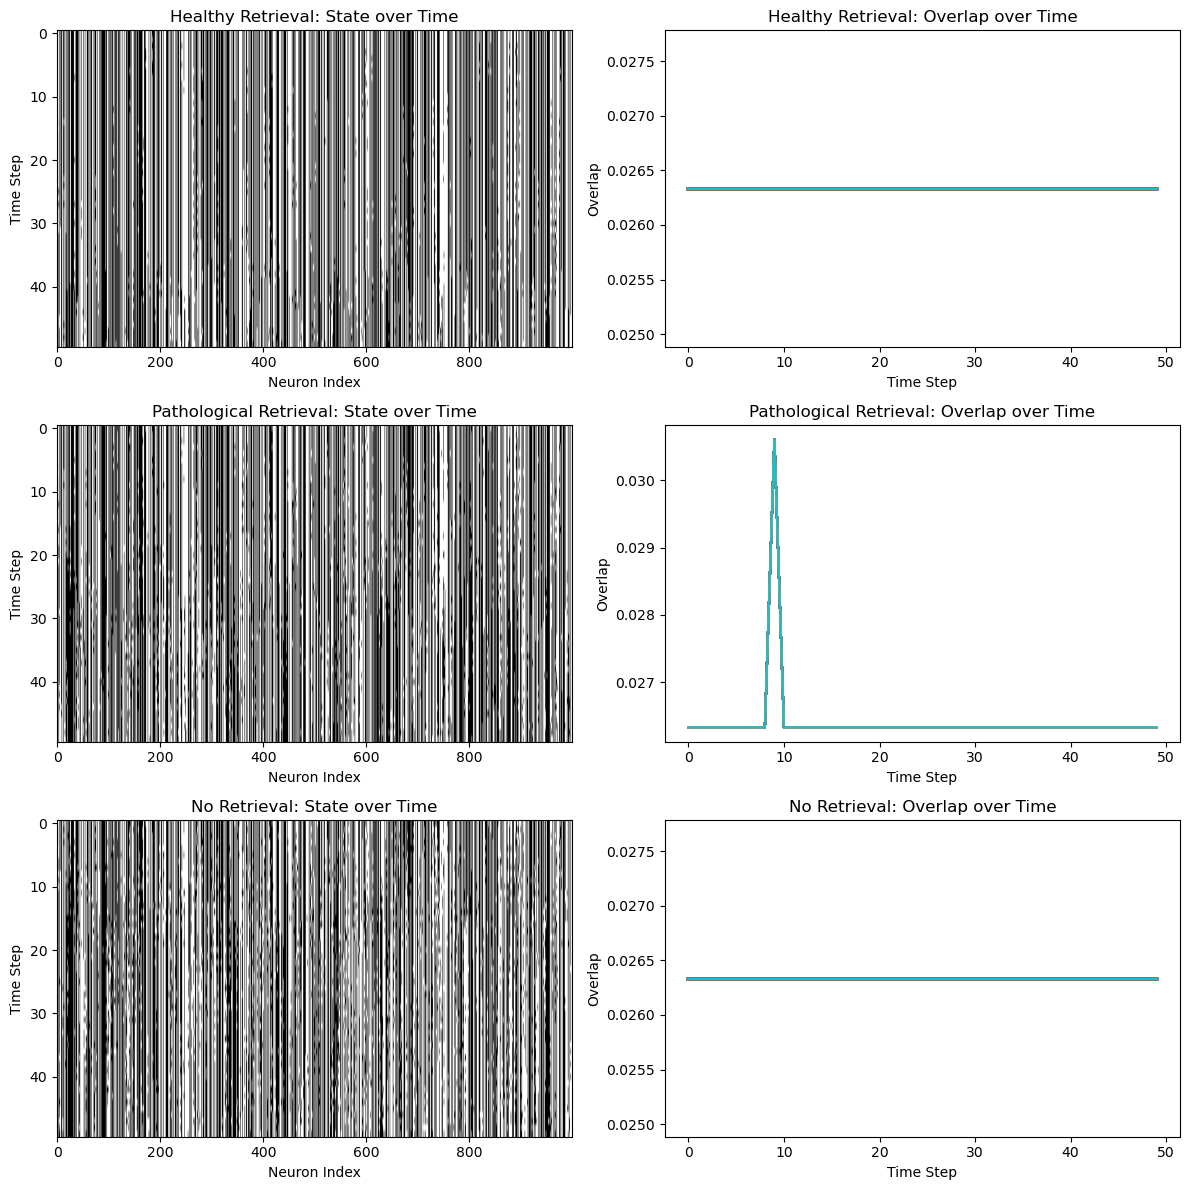

In [ ]:
# # =====================================================
# # graph of each one of the phases for pathological case, dynaminc in time vs. state and time vs. overlap.

# N = 1000

# alpha = 0.13 
# A_retrival = 1.0
# A_pathology = 0.7
# A_no_retrival = 0.5

# noise_var = 0.1
# max_tests = 30
# trials = 4
# T_dynamics = 50
# p = int(alpha * N)
# patterns = generate_patterns(N, p)
# W = hebbian_weights(patterns)


# W_retrival = W * A_retrival
# W_pathology = W * A_pathology
# W_no_retrival = W * A_no_retrival

# # Function to simulate dynamics over time
# def simulate_dynamics(W, patterns, T, noise_var):
#     overlaps_time = np.zeros((T, len(patterns)))
#     states_time = np.zeros((T, N))
#     s = patterns[0].copy()  # Start from the first pattern
#     for t in range(T):
#         s, _ = parallel_dynamics(W, s, var=noise_var, max_iters=1)
#         states_time[t] = s
#         overlaps = mean_overlap(s, patterns)
#         overlaps_time[t] = overlaps
#     return states_time, overlaps_time

# # Simulate dynamics for each case
# states_retrival, overlaps_retrival = simulate_dynamics(W_retrival, patterns, T_dynamics, noise_var)
# states_pathology, overlaps_pathology = simulate_dynamics(W_pathology, patterns, T_dynamics, noise_var)
# states_no_retrival, overlaps_no_retrival = simulate_dynamics(W_no_retrival, patterns, T_dynamics, noise_var)

# # Plotting
# fig, axs = plt.subplots(3, 2, figsize=(12, 12))

# # Healthy retrieval
# axs[0, 0].imshow(states_retrival, aspect='auto', cmap='binary')
# axs[0, 0].set_title('Healthy Retrieval: State over Time')
# axs[0, 0].set_xlabel('Neuron Index')
# axs[0, 0].set_ylabel('Time Step')
# axs[0, 1].plot(overlaps_retrival)
# axs[0, 1].set_title('Healthy Retrieval: Overlap over Time')
# axs[0, 1].set_xlabel('Time Step')
# axs[0, 1].set_ylabel('Overlap')

# # Pathological retrieval
# axs[1, 0].imshow(states_pathology, aspect='auto', cmap='binary')
# axs[1, 0].set_title('Pathological Retrieval: State over Time')
# axs[1, 0].set_xlabel('Neuron Index')
# axs[1, 0].set_ylabel('Time Step')
# axs[1, 1].plot(overlaps_pathology)
# axs[1, 1].set_title('Pathological Retrieval: Overlap over Time')
# axs[1, 1].set_xlabel('Time Step')
# axs[1, 1].set_ylabel('Overlap')

# # No retrieval
# axs[2, 0].imshow(states_no_retrival, aspect='auto', cmap='binary')
# axs[2, 0].set_title('No Retrieval: State over Time')
# axs[2, 0].set_xlabel('Neuron Index')
# axs[2, 0].set_ylabel('Time Step')
# axs[2, 1].plot(overlaps_no_retrival)
# axs[2, 1].set_title('No Retrieval: Overlap over Time')
# axs[2, 1].set_xlabel('Time Step')
# axs[2, 1].set_ylabel('Overlap')
# plt.tight_layout()
# plt.show()



In [9]:
def overlaps_all(s, patterns):
    return (patterns @ s) / s.size


def dominant_attractor(s, patterns, m_th=0.2):
    ovs = overlaps_all(s, patterns)
    mu = np.argmax(np.abs(ovs))
    return mu if np.abs(ovs[mu]) > m_th else -1


def build_pathological_network(patterns, A, lam, eta, T_forget):
    W = hebbian_weights(patterns) * A

    for t in range(T_forget):
        # decaimiento global
        W = weight_decay(W, lam, t+1)

        # unlearning tipo Kinouchi sobre atractor visitado
        mu = np.random.randint(len(patterns))
        s_att, _ = parallel_dynamics(W, patterns[mu])
        W = unlearning_step(W, s_att, eta)

    return W
def cognitive_dynamics(W, s0, patterns, noise_var, T_dyn, m_th=0.2):
    history = []
    attractor_seq = []

    s = s0.copy()
    for t in range(T_dyn):
        s = sign_vec(W @ s + np.random.normal(0, noise_var, size=s.shape))
        history.append(s.copy())
        attractor_seq.append(dominant_attractor(s, patterns, m_th))

    return np.array(history), np.array(attractor_seq)

def pseudo_attractor_lifetimes(attractor_seq):
    lifetimes = []
    current = attractor_seq[0]
    life = 1

    for mu in attractor_seq[1:]:
        if mu == current and mu != -1:
            life += 1
        else:
            if current != -1:
                lifetimes.append(life)
            current = mu
            life = 1

    if current != -1:
        lifetimes.append(life)

    return lifetimes
def attractor_jumps(attractor_seq):
    jumps = []
    for t in range(1, len(attractor_seq)):
        if attractor_seq[t] != attractor_seq[t-1]:
            if attractor_seq[t] != -1 and attractor_seq[t-1] != -1:
                jumps.append((t, attractor_seq[t-1], attractor_seq[t]))
    return jumps


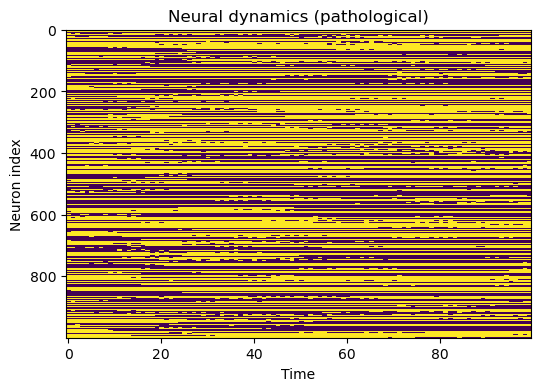

In [53]:
# Parámetros
alpha = 0.13
A = 0.8              # patológico
T_dyn = 100
m_th = 0.2

p = int(alpha * N)
patterns = generate_patterns(N, p)

# 1. red patológica
W_path = build_pathological_network(
    patterns, A, lam, eta, T_forget
)

# 2. estado inicial
s0 = corrupt_pattern(patterns[0], 0.2)

# 3. dinámica cognitiva
history, attractor_seq = cognitive_dynamics(
    W_path, s0, patterns, noise_var, T_dyn, m_th
)

# 4. métricas
lifetimes = pseudo_attractor_lifetimes(attractor_seq)
jumps = attractor_jumps(attractor_seq)

plt.figure(figsize=(6,4))
plt.imshow(history.T, aspect="auto", interpolation="nearest")
plt.xlabel("Time")
plt.ylabel("Neuron index")
plt.title("Neural dynamics (pathological)")
plt.show()


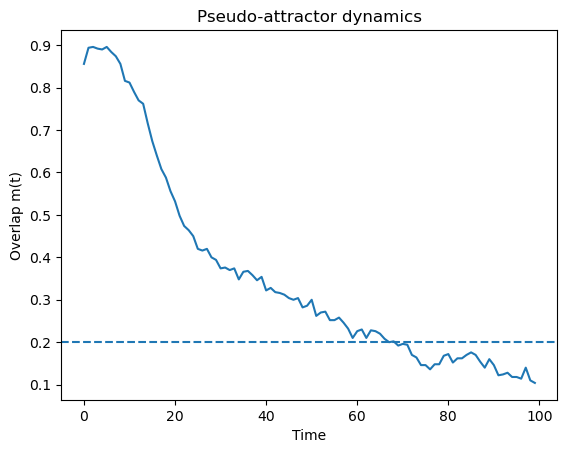

In [54]:
ms = [(patterns[0] @ s) / N for s in history]

plt.figure()
plt.plot(ms)
plt.axhline(m_th, linestyle="--")
plt.xlabel("Time")
plt.ylabel("Overlap m(t)")
plt.title("Pseudo-attractor dynamics")
plt.show()


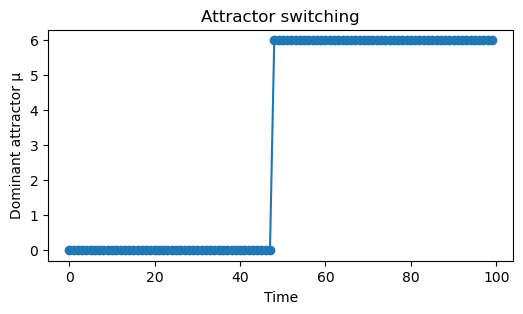

In [55]:
plt.figure(figsize=(6,3))
plt.plot(attractor_seq, marker="o")
plt.xlabel("Time")
plt.ylabel("Dominant attractor μ")
plt.title("Attractor switching")
plt.show()


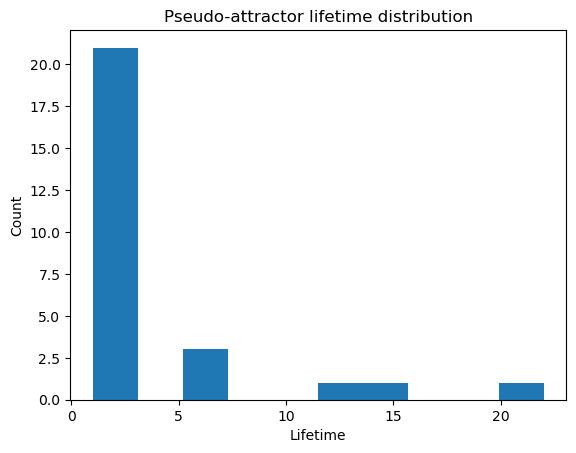

Mean lifetime: 3.7037037037037037
Number of jumps: 26


In [52]:
plt.figure()
plt.hist(lifetimes, bins=10)
plt.xlabel("Lifetime")
plt.ylabel("Count")
plt.title("Pseudo-attractor lifetime distribution")
plt.show()

print("Mean lifetime:", np.mean(lifetimes))
print("Number of jumps:", len(jumps))


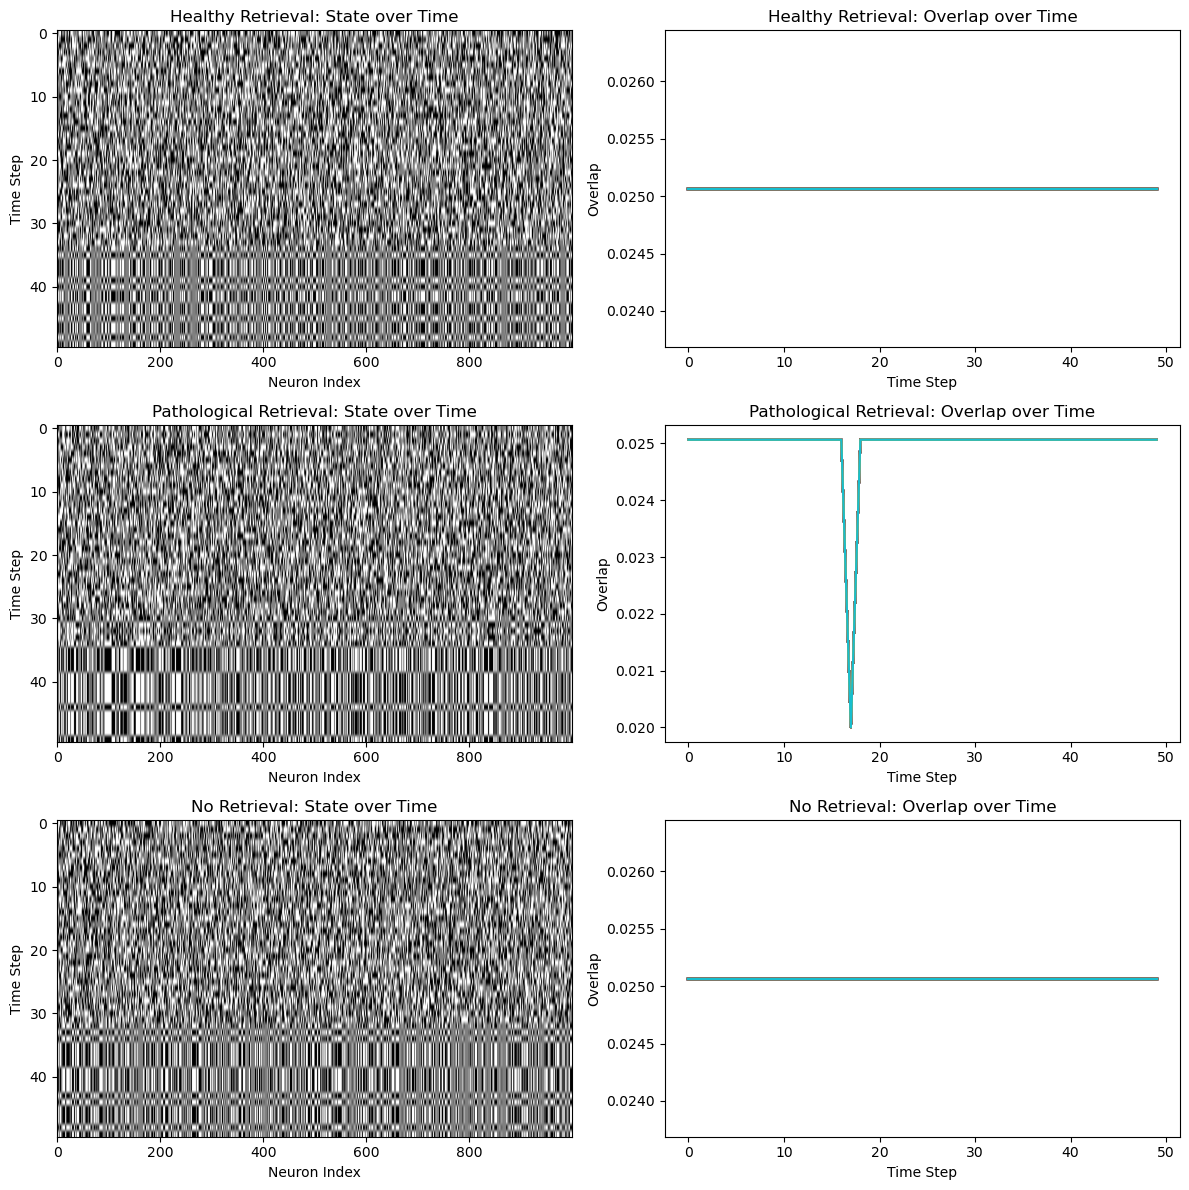

In [8]:
alpha = 0.13 
A_retrival = 1.0
A_pathology = 0.7
A_no_retrival = 0.5

T_dynamics = 50
def parallel_dynamics_history(W, s0, var=0.0, max_iters=100):
    s = s0.copy()
    history = [s.copy()]

    for it in range(max_iters):
        noise = np.random.normal(0, var, size=s.shape)
        s_new = sign_vec(W @ s + noise)
        history.append(s_new.copy())

        if np.array_equal(s_new, s):
            break
        s = s_new

    return np.array(history)


p = int(alpha * N)
patterns = generate_patterns(N, p)

W = hebbian_weights(patterns)
W_retrival = W* A_retrival
W_pathology = W* A_pathology
W_no_retrival = W* A_no_retrival

def simulate_dynamics(W, patterns, T, noise_var):
    overlaps_time = np.zeros((T, len(patterns)))
    states_time = np.zeros((T, N))
    s = patterns[0].copy()  # Start from the first pattern
    for t in range(T):
        W = weight_decay(W, lam, t+1)
        i = np.random.randint(p)
        s, _ = parallel_dynamics(W, patterns[i])
        W = unlearning_step(W, s, eta=eta)
        states_time[t] = s
        overlaps = mean_overlap(s, patterns)
        overlaps_time[t] = overlaps
    return states_time, overlaps_time


states_retrival, overlaps_retrival = simulate_dynamics(W_retrival, patterns, T_dynamics, noise_var)
states_pathology, overlaps_pathology = simulate_dynamics(W_pathology, patterns, T_dynamics, noise_var)
states_no_retrival, overlaps_no_retrival = simulate_dynamics(W_no_retrival, patterns, T_dynamics, noise_var)

# Plotting
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

# Healthy retrieval
axs[0, 0].imshow(states_retrival, aspect='auto', cmap='binary')
axs[0, 0].set_title('Healthy Retrieval: State over Time')
axs[0, 0].set_xlabel('Neuron Index')
axs[0, 0].set_ylabel('Time Step')
axs[0, 1].plot(overlaps_retrival)
axs[0, 1].set_title('Healthy Retrieval: Overlap over Time')
axs[0, 1].set_xlabel('Time Step')
axs[0, 1].set_ylabel('Overlap')

# Pathological retrieval
axs[1, 0].imshow(states_pathology, aspect='auto', cmap='binary')
axs[1, 0].set_title('Pathological Retrieval: State over Time')
axs[1, 0].set_xlabel('Neuron Index')
axs[1, 0].set_ylabel('Time Step')
axs[1, 1].plot(overlaps_pathology)
axs[1, 1].set_title('Pathological Retrieval: Overlap over Time')
axs[1, 1].set_xlabel('Time Step')
axs[1, 1].set_ylabel('Overlap')

# No retrieval
axs[2, 0].imshow(states_no_retrival, aspect='auto', cmap='binary')
axs[2, 0].set_title('No Retrieval: State over Time')
axs[2, 0].set_xlabel('Neuron Index')
axs[2, 0].set_ylabel('Time Step')
axs[2, 1].plot(overlaps_no_retrival)
axs[2, 1].set_title('No Retrieval: Overlap over Time')
axs[2, 1].set_xlabel('Time Step')
axs[2, 1].set_ylabel('Overlap')
plt.tight_layout()
plt.show()






In [ ]:
mean_activity = np.mean(history, axis=1)

plt.figure()
plt.plot(mean_activity)
plt.xlabel("Time")
plt.ylabel("⟨s⟩")
plt.title("Mean neural activity vs time")
plt.show()


In [ ]:
plt.figure(figsize=(6,4))
plt.imshow(history.T, aspect="auto", cmap="gray", interpolation="nearest")
plt.xlabel("Time")
plt.ylabel("Neuron index")
plt.title("Neural state evolution (pathological)")
plt.show()


Se observa en el panel izquierdo en la ausencia de olvido y unlearning, la dinámica converge siempre a atractores informativos hasta llegar cerca de la capacidad clásica
En cambio en la segunda imagen, se muestra que la patología no destruye los atractores si no que su contenido informacional

“Dynamic phase diagram of the associative memory network in the 
(
𝛼
,
𝐴
)
(α,A) plane, showing healthy retrieval, pathological retrieval, and non-retrieval regimes.”


- Phase classification is based on asymptotic overlaps and mutual information, not solely on dynamical stability.

In [ ]:
#mμ​(t)=N1​ξμ⋅s(t)>mth​

m_th = 0.2

def dominant_attractor(overlaps, m_th=0.2):
    """
    Returns index of dominant pattern or -1 if none
    """
    mu = np.argmax(np.abs(overlaps))
    if np.abs(overlaps[mu]) > m_th:
        return mu
    return -1

def pseudo_attractor_lifetimes(history, patterns, m_th=0.2):
    lifetimes = []
    current_mu = None
    current_life = 0

    for s in history:
        ovs = overlaps(s, patterns)
        mu = dominant_attractor(ovs, m_th)

        if mu == current_mu and mu != -1:
            current_life += 1
        else:
            if current_mu is not None and current_mu != -1:
                lifetimes.append(current_life)
            current_mu = mu
            current_life = 1 if mu != -1 else 0

    if current_mu is not None and current_mu != -1:
        lifetimes.append(current_life)

    return lifetimes

def attractor_jumps(history, patterns, m_th=0.2):
    attractor_sequence = []

    for s in history:
        ovs = overlaps(s, patterns)
        attractor_sequence.append(dominant_attractor(ovs, m_th))

    jumps = []
    for t in range(1, len(attractor_sequence)):
        if (attractor_sequence[t] != attractor_sequence[t-1] and
            attractor_sequence[t] != -1 and
            attractor_sequence[t-1] != -1):
            jumps.append((t, attractor_sequence[t-1], attractor_sequence[t]))

    return attractor_sequence, jumps


In [ ]:
# parámetros ya fijados
alpha = 0.12
A_pathology = 0.6
p = int(alpha * N)

patterns = generate_patterns(N, p)
W = hebbian_weights(patterns) * A_pathology

# aplicar patología
Wp = W.copy()
for t in range(T_forget):
    Wp = weight_decay(Wp, lam, t+1)
    mu = np.random.randint(p)
    s_tmp, _ = parallel_dynamics(Wp, patterns[mu])
    Wp = unlearning_step(Wp, s_tmp, eta)

# dinámica
mu0 = 0
s0 = corrupt_pattern(patterns[mu0], 0.2)
history = parallel_dynamics_history(Wp, s0, var=noise_var, max_iters=100)


In [ ]:
overlap_matrix = np.array([
    overlaps(s, patterns) for s in history
])

plt.figure(figsize=(6,4))
plt.plot(np.abs(overlap_matrix[:, :5]))
plt.axhline(0.2, linestyle="--", color="k")
plt.xlabel("Time")
plt.ylabel("Overlap")
plt.title("Overlap with first 5 patterns")
plt.show()


In [ ]:
attractor_seq, jumps = attractor_jumps(history, patterns)

plt.figure(figsize=(6,3))
plt.plot(attractor_seq, marker='o')
plt.xlabel("Time")
plt.ylabel("Dominant attractor μ")
plt.title("Attractor switching (pathological)")
plt.show()

print("Detected jumps (t, μ_before → μ_after):")
for j in jumps:
    print(j)


In [ ]:
lifetimes = pseudo_attractor_lifetimes(history, patterns)

plt.figure()
plt.hist(lifetimes, bins=10)
plt.xlabel("Lifetime (iterations)")
plt.ylabel("Count")
plt.title("Pseudo-attractor lifetime distribution")
plt.show()

print("Mean lifetime:", np.mean(lifetimes))


In [4]:
#extension de la anterior
def MI_vs_A(alpha, A_vals, pathological=False,
            N=1000, noise_var=0.1, max_tests=30, trials=3,
            lam=0.01, eta=0.02, T_forget=10):

    p = int(alpha * N)
    MI = []

    for A in A_vals:
        MI_A = []

        for _ in range(trials):
            patterns = generate_patterns(N, p)
            W = hebbian_weights(patterns) * A

            if pathological:
                Wp = W.copy()
                for t in range(T_forget):
                    Wp = weight_decay(Wp, lam, t+1)
                    i = np.random.randint(len(patterns))
                    s, _ = parallel_dynamics(Wp, patterns[i], var=noise_var)
                    Wp = unlearning_step(Wp, s, eta=eta)
                W_eff = Wp
            else:
                W_eff = W

            MI_A.append(
                mean_mutual_information(W_eff, patterns,
                                        noise_var, max_tests)
            )

        MI.append(np.mean(MI_A))

    return np.array(MI)

def extract_Ac(A_vals, MI_vals, I_c=0.05):
    for i in range(1, len(A_vals)):
        if MI_vals[i-1] < I_c and MI_vals[i] >= I_c:
            # linear interpolation
            A1, A2 = A_vals[i-1], A_vals[i]
            I1, I2 = MI_vals[i-1], MI_vals[i]
            return A1 + (I_c - I1) * (A2 - A1) / (I2 - I1)
    return np.nan

In [5]:
alphas = np.linspace(0.05, 0.18, 8)
A_vals = np.linspace(0.4, 1.6, 25)

Ac_healthy = []
Ac_path = []

for alpha in alphas:
    MI_0 = MI_vs_A(alpha, A_vals, pathological=False)
    MI_p = MI_vs_A(alpha, A_vals, pathological=True)

    Ac_healthy.append(extract_Ac(A_vals, MI_0))
    Ac_path.append(extract_Ac(A_vals, MI_p))

Ac_healthy = np.array(Ac_healthy)
Ac_path = np.array(Ac_path)


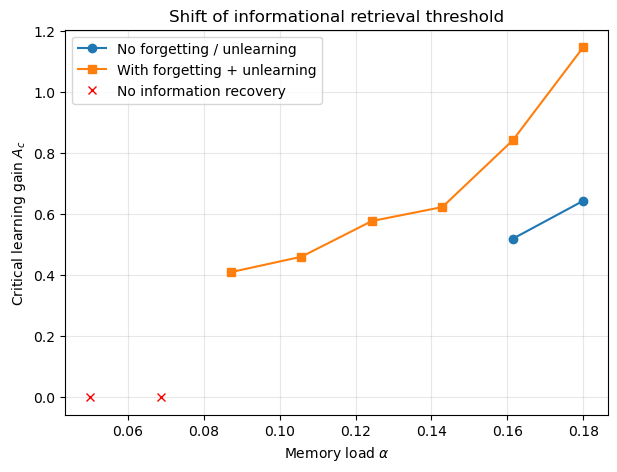

In [6]:
plt.figure(figsize=(7,5))

mask0 = ~np.isnan(Ac_healthy)
maskp = ~np.isnan(Ac_path)

plt.plot(alphas[mask0], Ac_healthy[mask0],
         'o-', label="No forgetting / unlearning")

plt.plot(alphas[maskp], Ac_path[maskp],
         's-', label="With forgetting + unlearning")

plt.plot(alphas[~maskp], [0]*np.sum(~maskp),
         'rx', label="No information recovery")

plt.xlabel(r"Memory load $\alpha$")
plt.ylabel(r"Critical learning gain $A_c$")
plt.title("Shift of informational retrieval threshold")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


figura que representa el umbral informacional 
𝐴(α) comparando dos regímenes dinámicos distintos

El forgetting + unlearning:

no elimina inmediatamente los atractores

desplaza la transición

convierte un sistema recuperable en uno patológico

Eso es exactamente lo que se observa clínicamente.

En cerebros sanos:

la pérdida de sinapsis reduce capacidad, pero no destruye semántica

En cerebros con degeneración:

la misma carga semántica se vuelve no recuperable

aparece confusión, no olvido puro

Alzheimer∼desplazamiento del umbral informacional:
Synaptic decay and unlearning do not simply reduce retrieval accuracy, but shift the informational retrieval threshold, inducing a pathological regime where overlaps persist in the absence of semantic information.


In [7]:
mask0 = ~np.isnan(Ac_healthy)
maskp = ~np.isnan(Ac_path)

alpha0 = alphas[mask0]
A0 = Ac_healthy[mask0]

alphap = alphas[maskp]
Ap = Ac_path[maskp]

In [8]:
from scipy.optimize import curve_fit

def Ac_mf(alpha, K):
    return K * np.sqrt(alpha)

K0, _ = curve_fit(Ac_mf, alpha0, A0)
Kp, _ = curve_fit(Ac_mf, alphap, Ap)

K0 = K0[0]
Kp = Kp[0]

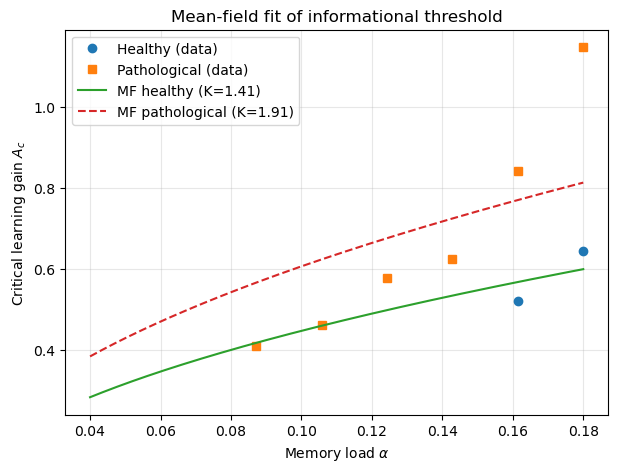

In [9]:
alpha_fit = np.linspace(0.04, 0.18, 200)

plt.figure(figsize=(7,5))

plt.plot(alpha0, A0, 'o', label="Healthy (data)")
plt.plot(alphap, Ap, 's', label="Pathological (data)")

plt.plot(alpha_fit, Ac_mf(alpha_fit, K0),
         '-', label=f"MF healthy (K={K0:.2f})")

plt.plot(alpha_fit, Ac_mf(alpha_fit, Kp),
         '--', label=f"MF pathological (K={Kp:.2f})")

plt.xlabel(r"Memory load $\alpha$")
plt.ylabel(r"Critical learning gain $A_c$")
plt.legend()
plt.grid(alpha=0.3)
plt.title("Mean-field fit of informational threshold")
plt.show()


Ajuste con modelo de Mean-field

In [10]:
def semantic_confusion_metrics(W, patterns, noise_var=0.1):
    """
    Returns:
    m_max : dominant overlap
    S    : entropy of overlaps
    """
    N = patterns.shape[1]
    i = np.random.randint(len(patterns))
    s0 = patterns[i]
    sf, _ = parallel_dynamics(W, s0, var=noise_var)

    m = overlaps(sf, patterns)
    abs_m = np.abs(m)

    m_max = np.max(abs_m)

    p = abs_m / np.sum(abs_m + 1e-12)
    S = -np.sum(p * np.log(p + 1e-12))

    return m_max, S



In [11]:
S_map = np.zeros_like(phase_pathology)
mmax_map = np.zeros_like(phase_pathology)

for iA, A in enumerate(A_vals):
    for ia, alpha in enumerate(alphas):

        if phase_pathology[iA, ia] != 1:  # solo patológico
            continue

        p = int(alpha * N)
        patterns = generate_patterns(N, p)
        W = hebbian_weights(patterns) * A

        # aplicar patología
        for t in range(T_forget):
            W = weight_decay(W, lam, t+1)
            i = np.random.randint(len(patterns))
            s, _ = parallel_dynamics(W, patterns[i], var=noise_var)
            W = unlearning_step(W, s, eta=eta)

        m_max, S = semantic_confusion_metrics(W, patterns, noise_var)

        S_map[iA, ia] = S
        mmax_map[iA, ia] = m_max


IndexError: index 10 is out of bounds for axis 0 with size 10

In [ ]:
plt.figure(figsize=(6,5))

plt.imshow(
    S_map,
    origin="lower",
    aspect="auto",
    extent=[alphas[0], alphas[-1], A_vals[0], A_vals[-1]],
    cmap="magma"
)

plt.colorbar(label="Semantic entropy $S$")
plt.xlabel(r"Memory load $\alpha$")
plt.ylabel("Learning gain A")
plt.title("Semantic confusion regime (pathological retrieval)")
plt.show()


Este panel muestra:

Zonas con alta entropía:

muchos patrones contribuyen

ninguno domina

mientras el overlap total no es cero

y la MI es nula

Interpretación directa:

La red recuerda categorías, no instancias.

Eso es confusión semántica.